In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
sns.set_theme(style="darkgrid")
warnings.filterwarnings('ignore')

In [2]:
# Read the data
data = pd.read_csv('../dataset/breast-cancer-wisconsin.data')

In [3]:
# Drop Unnamed: 32 column and id column
data.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)

In [4]:
# Encode the diagnosis column
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

In [5]:
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

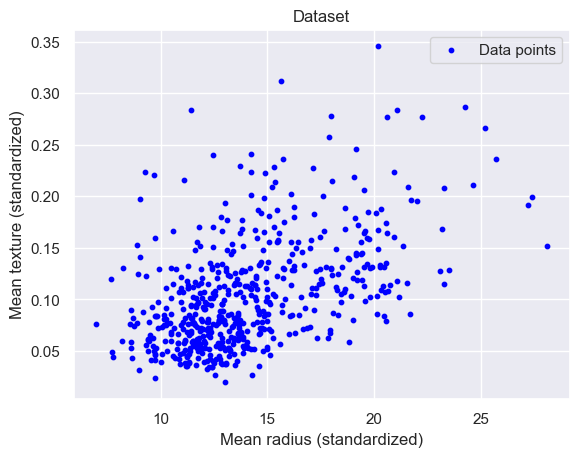

In [6]:
# Plot
plt.title('Dataset')
plt.scatter(X.iloc[:, 0], X.iloc[:, 5], color='blue', s=10., label='Data points')
plt.axis('tight')
plt.xlabel('Mean radius (standardized)')
plt.ylabel('Mean texture (standardized)')
plt.legend()
plt.show()

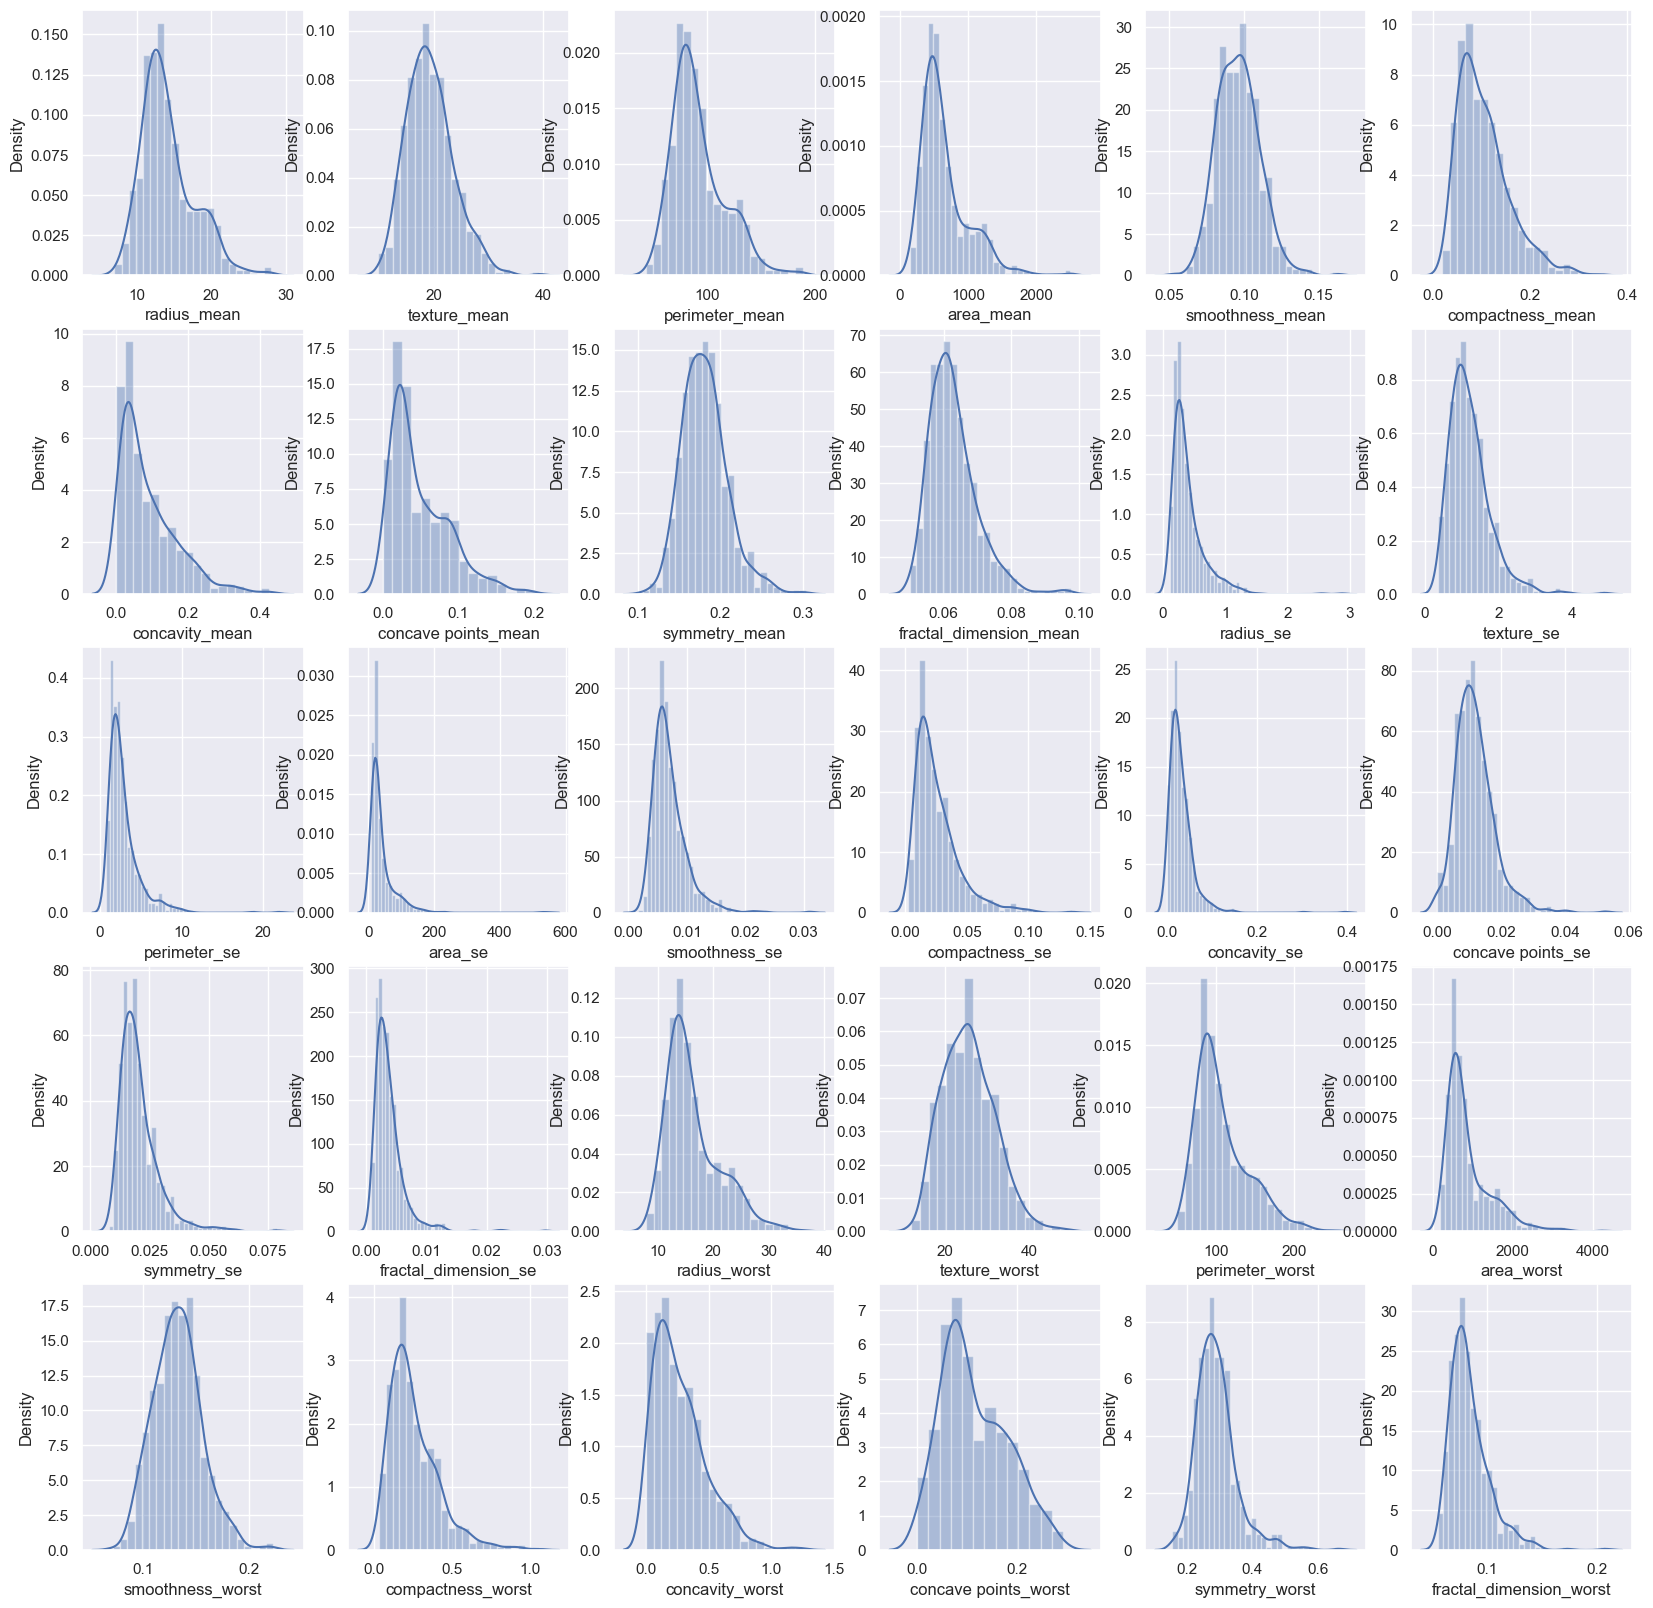

In [7]:
fig, ax = plt.subplots(5, 6, figsize=(20, 20))
for variable, subplot in zip(X.columns, ax.flatten()):
    sns.distplot(X[variable], ax=subplot)
plt.show()

In [8]:
# Split the data into train and test with 80% and 20% respectively, stratify the data
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
# Hyper-parameters tuning
def grid_search():
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LogisticRegression
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'penalty': ['l1', 'l2'],
                  'solver': ['liblinear', 'saga'],
                  'max_iter': [100, 1000, 2500, 5000]}
    grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=2)
    grid.fit(X_train, y_train)
    return grid.best_params_

In [10]:
best_params = grid_search()

Fitting 5 folds for each of 112 candidates, totalling 560 fits
[CV] END C=0.001, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .....C=0.001, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....C=0.001, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....C=0.001, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....C=0.001, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....C=0.001, max_iter=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.001, max_iter=100, penalty=l2, so

In [20]:
best_params

{'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [11]:
# Train the model with best hyper-parameters
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(**best_params)
model.fit(X_train, y_train)

LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [12]:
# Evaluate the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))
print('Classification Report: ', classification_report(y_test, y_pred))

Accuracy:  0.9473684210526315
Confusion Matrix:  [[70  2]
 [ 4 38]]
Classification Report:                precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



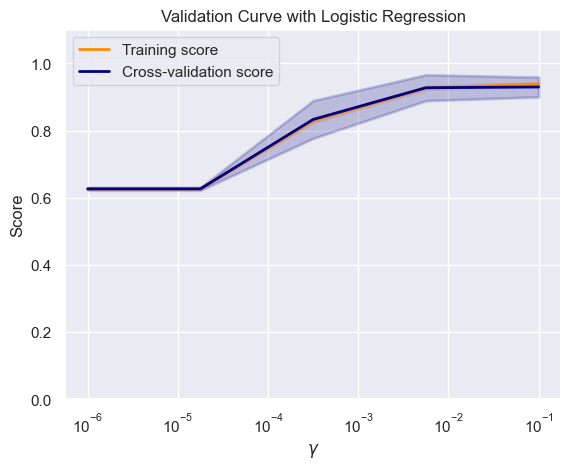

In [19]:
# Plot validation curve
from sklearn.model_selection import validation_curve
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    model, X_train, y_train, param_name="C", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic Regression")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
                color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

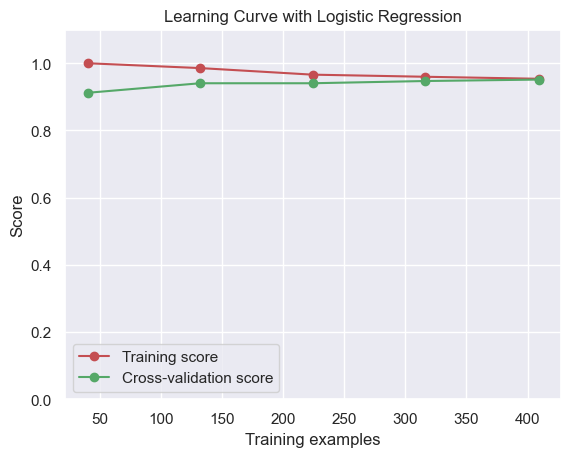

In [14]:
# Plot learning curve
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(), X_train, y_train, cv=10, scoring='accuracy', n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Learning Curve with Logistic Regression")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")
plt.legend(loc="best")
plt.show()

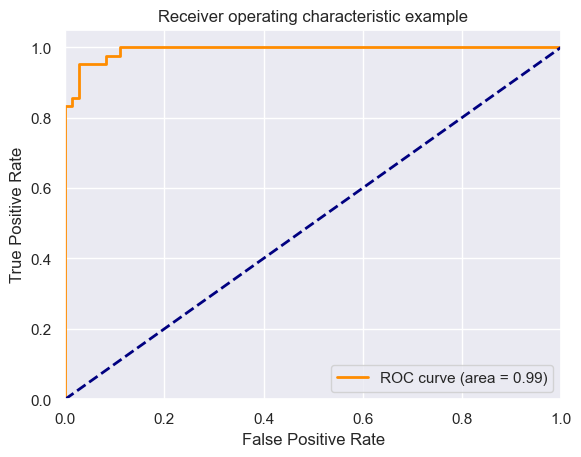

In [15]:
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
y_score = model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
        lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

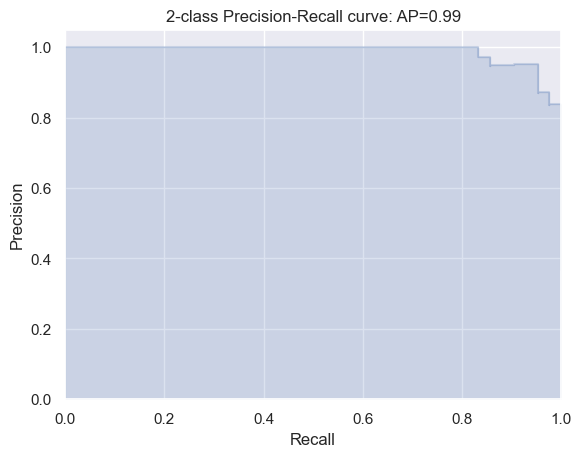

In [16]:
# Plot Precision-Recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
precision, recall, _ = precision_recall_curve(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2,
        where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
        average_precision))
plt.show()


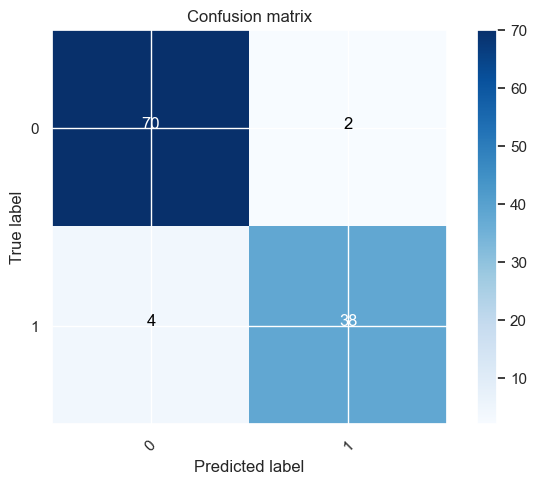

In [17]:
# Plot confusion matrix, annotated with the number of samples
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'], rotation=45)
plt.yticks(tick_marks, ['0', '1'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
plt.show()

In [18]:
# Get f1 score
from sklearn.metrics import f1_score
print('F1 score: ', f1_score(y_test, y_pred))

F1 score:  0.9268292682926829


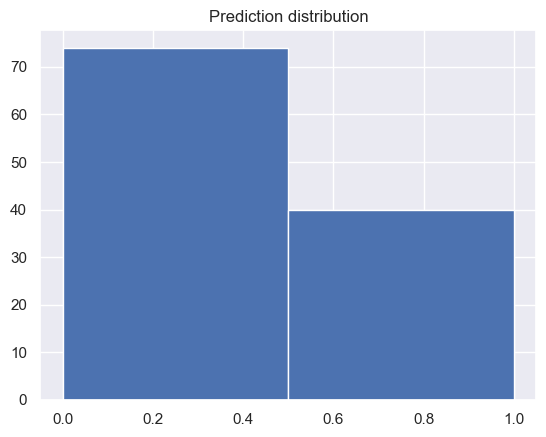

In [21]:
# Plot prediction distribution
plt.hist(y_pred, bins=2)
plt.title('Prediction distribution')
plt.show()

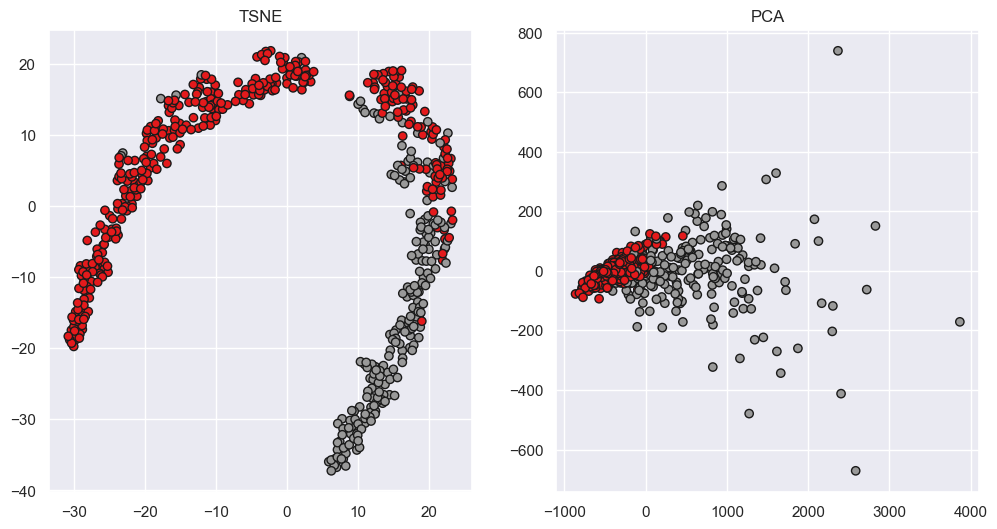

In [22]:
# Embedding visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Create a TSNE model and fit it to the data
tsne = TSNE(n_components=2, random_state=0)
tsne2d = tsne.fit_transform(X)

# Create a PCA model and fit it to the data
pca = PCA(n_components=2, random_state=0)
pca2d = pca.fit_transform(X)

# Plot the data tsne and pca
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(tsne2d[:, 0], tsne2d[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
ax[0].set_title('TSNE')
ax[1].scatter(pca2d[:, 0], pca2d[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
ax[1].set_title('PCA')
plt.show()

In [24]:
# Fit model LogisticRegression with PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=20)),
                    ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.965
